# Hometask №1
### Data processing & descriptors search

In [105]:
import pandas as pd

import numpy as np

import re

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import rdDepictor
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # supress rdkit warnings

import cirpy

import pubchempy as pcp

from mp_api.client import MPRester

from bs4 import BeautifulSoup
import requests

from PaDEL_pywrapper import PaDEL
from PaDEL_pywrapper import descriptors
from PaDEL_pywrapper.descriptor import AtomCount, BondCount, Constitutional, EStateAtomType, ExtendedTopochemicalAtom, MDE, MLFER
from PaDEL_pywrapper.descriptor import RotatableBondsCount, CarbonTypes, HBondAcceptorCount, HBondDonorCount, PathCount, ChiChain, ChiCluster, ChiPath
from PaDEL_pywrapper.descriptor import HybridizationRatio, LargestChain, LargestPiSystem, LongestAliphaticChain, RuleOfFive, VABC, WeightedPath, CPSA
from PaDEL_pywrapper.descriptor import InformationContent, WalkCount, TopologicalDistanceMatrix, APol, AcidicGroupCount, BasicGroupCount, FragmentComplexity

import string

import seaborn as sns

import matplotlib.pyplot as plt

### Dataset

In [3]:
data = pd.read_csv("C:\\Users\\User\Downloads\\1.csv", sep=',')
data

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier
0,10.1016/j.physb.2010.04.052,4/29/2010,Physica B: Condensed Matter,EXCITONSPECTRAENERGYBANDSTRUCTURECUALS2CRYSTALS,CuGaSe2,0.0,NaN,el_cde_tables,"[['Cu', 1.0], ['Ga', 1.0], ['Se', 2.0]]",1.8235,n
1,10.1016/j.jep.2012.08.025,8/29/2012,Journal of Ethnopharmacology,INVITROINVIVOANTIMICROBIALACTIVITYALGERIANHOGG...,WC,0.0,NaN,el_cde_tables,NaN,2.66,n
2,10.1016/j.physb.2011.08.013,8/18/2011,Physica B: Condensed Matter,OPTICALPROPERTIESGEASTETHINFILMS,Te–Te,0.0,NaN,el_mylogic,NaN,2.99,Refractive index parameters
3,10.1016/j.jnoncrysol.2011.04.001,5/3/2011,Journal of Non-Crystalline Solids,FOURIERTRANSFORMINFRAREDSPECTROSCOPYINVESTIGAT...,SiC,0.0,NaN,el_mylogic,NaN,2.55,RI (± 0.0001)
4,10.1039/C4PY00369A,8/12/2014,Polymer Chemistry,Camptothecin prodrug block copolymer micelles ...,CPT,0.0,NaN,rsc_cde_text,NaN,3,n
...,...,...,...,...,...,...,...,...,...,...,...
4995,10.1016/j.ejpb.2004.05.003,6/26/2004,European Journal of Pharmaceutics and Biopharm...,APPLYINGPATTERNRECOGNITIONMETHODSSTRUCTUREPROP...,Dihydropyridine,0.0,NaN,el_mylogic,NaN,1.679,Index of refraction
4996,10.1039/C4CS00424H,NaN,NaN,NaN,TiO2,0.0,NaN,snowball,"[['O', 2.0], ['Ti', 1.0]]",2.5,refractive index
4997,10.1016/j.numecd.2015.10.010,11/14/2015,"Nutrition, Metabolism and Cardiovascular Diseases",INCREASINGFRUITVEGETABLEINTAKENOEFFECTRETINALV...,cholesterol,0.0,NaN,el_cde_tables,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,4.28,n
4998,10.1016/j.solmat.2010.03.020,4/1/2010,Solar Energy Materials and Solar Cells,DISCUSSIONELECTRICALCHARACTERISTICSIIN013GA087...,SiO2,0.0,NaN,el_mylogic,NaN,1.467,Refractive index


In [306]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4555 non-null   object 
 2   Journal                 4555 non-null   object 
 3   Title                   4555 non-null   object 
 4   Name                    4992 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  597 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         2994 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


The following cleansing aspects are needed:
- extract journal names and years from DOI column
- find missing Titles
- find missing Names
- find missing normalised_names and uniform them
- uniform 'raw_value' column

### Handling duplicates

In [405]:
# number of duplicated rows
data.duplicated().sum()

22

In [406]:
# keep only one of two duplicates
data = data.drop_duplicates(keep='first')
data.shape

(4978, 11)

### Fixing the 'raw_value' column

In [407]:
def remove_range(string):
    """converts ranges into average value"""
    replace_items = ['–', 'to', ', ', '−', '…', '/', '~']
    for i in replace_items:
        if i in string:
            string = string.replace(i, '∼')
    if string[0]=='∼':
        string = string[1:]
    else:
        splitted_string = string.split('∼')
        try:
            string = str((float(splitted_string[0])+float(splitted_string[1]))/2)
        except:
            string = splitted_string[0]
    return string

def remove_bracket(string):
    """removes brackets from values"""
    string = string.replace('[', '(')
    string = string.replace(']', ')')
    import re
    if '(' in string:
        string = re.sub(r'\(.*?\)\ *', '', string)
        string = string.replace(' ', '')
    return string

def remove_error(string):
    """removes measurement error"""
    replace_items = [' ± ', '+']
    for i in replace_items:
        if i in string:
            string = string.replace(i, '±')
    if ' ± ' in string:
        splitted_string = string.split(' ± ')
    else:
        splitted_string = string.split('±')
    string = splitted_string[0]
    error = splitted_string[1]
    return [string, error]

In [411]:
for idx in data.index:
    v = data.loc[idx, 'raw_value']
    if '(' in v or '[':
        v = remove_bracket(v)
    if '±' in v or '+' in v:
        v = remove_error(v)[0]
        try:
            data.at[idx, 'measurement_error'] = remove_error(v)[1]
        except:
            pass
    if '∼' in v or '~' in v or '–' in v or 'to' in v or ', ' in v or '…' in v or '/' in v or '−' in v:
        v = remove_range(v)
    data.at[idx, 'raw_value'] = v

In [413]:
# print unhandled values
for idx in data.index:
    v = data.loc[idx, 'raw_value']
    try:
        float(v)
    except:
        print(f'Unhandled v = {v} in row {idx}')

Unhandled v = <2 in row 470
Unhandled v = 1.30 2.00 1.97 in row 1454
Unhandled v = 1.401b in row 1569
Unhandled v = 1.50000294,15 in row 2725
Unhandled v = 1.878 1.282 1.258 in row 4252
Unhandled v = 2.92 2.79 2.68 in row 4689


In [414]:
# drop invalid values and reset indexes
data = data.drop(labels=[470, 1454, 2725, 4252, 4689], axis=0)
# fix one value manually
data.at[1569, 'raw_value'] = '1.401'
# reset indexes
data.reset_index(inplace=True)
# convert everythinf into float
data['raw_value'] = data['raw_value'].apply(lambda x: float(x))
# check if the column has a float type finally
data['raw_value'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4973 entries, 0 to 4972
Series name: raw_value
Non-Null Count  Dtype  
--------------  -----  
4973 non-null   float64
dtypes: float64(1)
memory usage: 39.0 KB


### Handling outliers

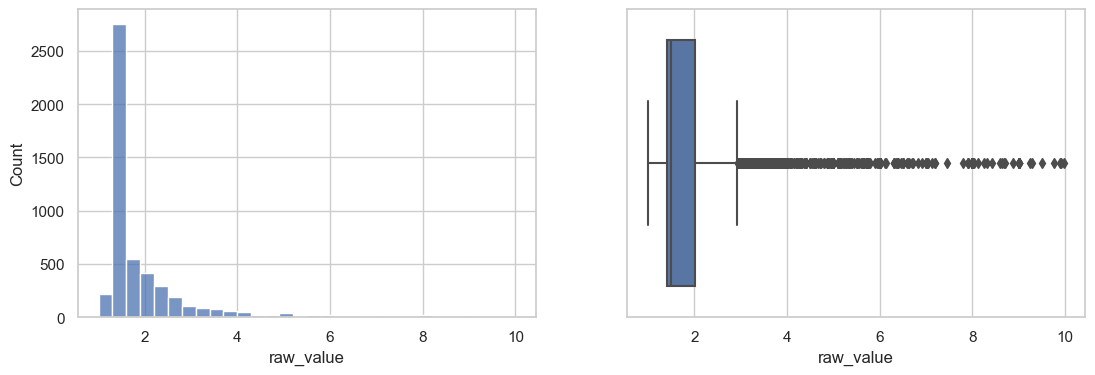

In [415]:
# outliers can be detected with the help of visualization tools
fig, axs = plt.subplots(ncols=2, figsize=(13, 4))
sns.set_style('whitegrid')
sns.histplot(data['raw_value'], kde = False, bins = 30, ax=axs[0])
sns.boxplot(x=data['raw_value'], ax=axs[1])
plt.show()

On the histogram and boxplot wee see that our data is skewed to minimum values and most of the data is located in the range from 1 to 3.

In [416]:
# remove outliers using boxplot
Q1 = data['raw_value'].quantile(0.25)
Q3 = data['raw_value'].quantile(0.75)
IQR = Q3 - Q1

filter = (data['raw_value'] >= Q1 - 1.5 * IQR) & (data['raw_value'] <= Q3 + 1.5 *IQR)
data = data.loc[filter]
data.shape

(4453, 12)

### Handling missing values in 'Name' and 'normalised_name'

In [417]:
# % of missing values for every column
data.isnull().sum() / data.shape[0] * 100

index                      0.000000
DOI                        0.000000
Date                       9.431844
Journal                    9.431844
Title                      9.431844
Name                       0.179654
measurement_error          0.000000
measurement_wavelength    87.514035
measurement_method         0.000000
normalised_name           40.332360
raw_value                  0.000000
specifier                  0.000000
dtype: float64

In [418]:
data_no_name = data[data['Name'].isna()==True]
data_no_name['normalised_name']

9                CCCO
3222        CCOC(C)=O
3250        Cc1ccccc1
3452      CCCCC(CC)CO
3742    Nc1cccc(Cl)c1
4007         O=[Si]=O
4210          CC(C)=O
4213        Nc1ccccc1
Name: normalised_name, dtype: object

We see that all missing names have SMILES in "normalised_name" column. So, we can obtain names by SMILES with the help of CIRpy library.

In [419]:
# fill in gaps in "Name" column
for idx in data.index:
    if type(data.loc[idx, 'Name'])!=str:
        norm_name = data.loc[idx, 'normalised_name']
        new_name = cirpy.resolve(norm_name, 'iupac_name')
        data.at[idx, 'Name'] = new_name
        print(norm_name, new_name)

CCCO Propan-1-ol
CCOC(C)=O Ethyl acetate
Cc1ccccc1 methylbenzene
CCCCC(CC)CO 2-Ethylhexan-1-ol
Nc1cccc(Cl)c1 3-Chloroaniline
O=[Si]=O Dioxosilane
CC(C)=O propan-2-one
Nc1ccccc1 Aniline


Now we can fill in missing values in "normalised_name" column with the help of PubChem API and CIRpy package. Even if "normalised_name" already exists we parse the line through the function, as we want all "normalised_name" values to be in SMILES format. SMILES format is necessary because most of the descriptors are calculated based on SMILES.

In [77]:
for idx in data.index:
    name = data.loc[idx, 'Name']
    try:
        smiles = pcp.get_compounds(name, 'formula')[0].isomeric_smiles
        data.at[idx, 'normalised_name'] = smiles
    except:
        try:
            smiles = pcp.get_compounds(name, 'name')[0].isomeric_smiles
            data.at[idx, 'normalised_name'] = smiles
        except:
            data.at[idx, 'normalised_name'] = np.nan

In [ ]:
for idx in data.index:
    smiles = data.loc[idx, 'normalised_name']
    name = data.loc[idx, 'Name']
    if type(smiles)!=str:
        try:
            new_smiles = cirpy.resolve(name, 'smiles')
        except:
            new_smiles = None
        data.at[idx, 'normalised_name'] = new_smiles

In [41]:
# result dataset (programming was made by supercomputer)
data = pd.read_csv("C:\\Users\\User\Downloads\\data_final.tsv", delimiter='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4453 entries, 0 to 4452
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   4453 non-null   int64  
 1   DOI                     4453 non-null   object 
 2   Date                    4033 non-null   object 
 3   Journal                 4033 non-null   object 
 4   Title                   4033 non-null   object 
 5   Name                    4453 non-null   object 
 6   measurement_error       4453 non-null   float64
 7   measurement_wavelength  556 non-null    object 
 8   measurement_method      4453 non-null   object 
 9   normalised_name         3922 non-null   object 
 10  raw_value               4453 non-null   float64
 11  specifier               4453 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 417.6+ KB


There are still missing SMILES. Among them we created a dictionary of names that can be eather corrected or converted to SMILES separately. Other names are deleted because they can not be converted into SMILES unambigously (ex. SnOx).

In [42]:
d_correct = {
            'As40Se60':'As2Se3', 'NMFA':'N-methyl-2-fluoroaniline', 'BiZnBo–':'BiZnBO', 'Si–O':'Si–O',
             'Li2O–GeO2':'Li2O–GeO2', 'GeO2–PbO':'GeO2–PbO', "TiO2's":'TiO2', 'ZnO–Ta2O5–B2O3':'ZnO–Ta2O5–B2O3',
             'CaO–SiO2':'CaO–SiO2', 'GeO2–Bi2O3':'GeO2–Bi2O3', 'Na2O–B2O3':'Na2O–B2O3', 'K2O–TeO2':'K2O–TeO2',
             'CH3–CH2–O–CH2–CH3':'diethyl ether', 'MgO–PbF2–SiO2':'MgO–PbF2–SiO2', 'O–O':'O2', 'F–B':'F–B',
             'PbO–Al2O3':'PbO–Al2O3', 'ZnO–Al2O3':'ZnO–Al2O3', '(−)–Sparteine':'Sparteine', 'PbF2–TeO2–B2O3–Eu2O3':'PbF2–TeO2–B2O3–Eu2O3',
             'CaC2':'Calcium Carbide', 'SiO2 – SnO2':'SiO2–SnO2', 'Ag–ZnO':'Ag–ZnO', 'ZnO –':'ZnO', 'La2O3–B2O3':'La2O3–B2O3',
             'PbO–Sb2O3–B2O3':'PbO–Sb2O3–B2O3', 'BPA–':'BPA', 'Na2O–SiO2':'Na2O–SiO2', 'SiO2(OH)':'HO3Si', 'TeO2–':'TeO2',
             'CH3(CH2)3OH':'butanol', 'TiO2(l)':'TiO2', 'Al(PO3)3':'AlP3O9', 'AgI–B2O3:V2O5':'AgI–B2O3–V2O5',
             'CaF2–Y2O3–ZnO':'CaF2–Y2O3–ZnO', 'Sb2O3–Na2O':'Sb2O3–Na2O', 'Te–Te':'Te–Te', 'TeO2–BaF2':'TeO2–BaF2',
             'SiO2–':'SiO2', 'K2O–B2O3':'K2O–B2O3', 'Ge–Ga–S':'Ge–Ga–S', 'NO3−':'nitrate', 'CuSO4·H2O':'copper sulfate monohydrate',
             'Li2O–Y2O3':'Li2O–Y2O3', 'PbF2–TeO2–B2O3–Sm2O3':'PbF2–TeO2–B2O3–Sm2O3', 'CuSO4·5H2O':'copper sulfate pentahydrate',
             'Na2CO3_aq_23':'Na2CO3', 'GeO2–SiO2':'GeO2–SiO2', 'GeS2–As2S3':'GeS2–As2S3', 'TeO2–B2O3–ZnO':'TeO2–B2O3–ZnO',
             'PbO–Bi2O3':'PbO–Bi2O3', 'ZnSb(wt':'ZnSb', 'K2O–B2O3–Bi2O3':'K2O–B2O3–Bi2O3', 'In2O3–Sc2O3':'In2O3–Sc2O3',
             'ZnO–B2O3':'ZnO–B2O3', 'TiO2–TeO2':'TiO2–TeO2', 'V2O5–GeO2':'V2O5–GeO2', 'Bi2O3–SiO2':'Bi2O3–SiO2',
             'SiO2–Nb2O5':'SiO2–Nb2O5', 'B2O3–SiO2':'B2O3–SiO2', 'SiC(100)':'SiC', 'SiO2–ZrO2':'SiO2–ZrO2',
             'MgO(1 0 0 )':'MgO', 'BaF2–PrF3':'BaF2–PrF3', 'PbO−PbF2−B2O3–Nd2O3':'PbO−PbF2−B2O3–Nd2O3', 'GeS2–Ga2S3–CdS':'GeS2–Ga2S3–CdS',
             'ZnF2–WO3–TeO2':'ZnF2–WO3–TeO2', 'Cd–Se':'Cd–Se', 'SiO2·P2O5':'SiO2–P2O5', 'PbO–TeO2':'PbO–TeO2',
             'TiO2–SiO2':'TiO2–SiO2', 'NO2–BF':'NO2–BF', 'Na2O–P2O5':'Na2O–P2O5'
             }

In [43]:
def complex_smiles(name):
    """makes joint SMILES from a system of molecules (like A-B-C)"""
    smiles_list = []
    names = name.split('–')
    for n in names:
        try:
            smiles = pcp.get_compounds(n, 'formula')[0].isomeric_smiles
        except:
            smiles = pcp.get_compounds(n, 'name')[0].isomeric_smiles
        smiles_list.append(smiles)
    return '.'.join(smiles_list)

In [44]:
for k, v in d_correct.items():
    if '–' in v:
        try:
            d_correct[k] = complex_smiles(v)
        except:
             d_correct[k] = None
    else:
        try:
            smiles = pcp.get_compounds(v, 'formula')[0].isomeric_smiles
            d_correct[k] = smiles
        except:
            try:
                smiles = pcp.get_compounds(v, 'name')[0].isomeric_smiles
                d_correct[k] = smiles
            except:
                d_correct[k] = None
d_correct

{'As40Se60': '[As](=[Se])[Se][As]=[Se]',
 'NMFA': 'CNC1=CC=CC=C1F',
 'BiZnBo–': '[B]=O.[Zn].[Bi]',
 'Si–O': '[Si].[O-2]',
 'Li2O–GeO2': '[Li+].[Li+].[O-2].O=[Ge]=O',
 'GeO2–PbO': 'O=[Ge]=O.O=[Pb]',
 "TiO2's": 'O=[Ti]=O',
 'ZnO–Ta2O5–B2O3': '[O-2].[Zn+2].[O-2].[O-2].[O-2].[O-2].[O-2].[Ta+5].[Ta+5].B(=O)OB=O',
 'CaO–SiO2': 'O=[Ca].O=[Si]=O',
 'GeO2–Bi2O3': 'O=[Ge]=O.O=[Bi]O[Bi]=O',
 'Na2O–B2O3': '[O-2].[Na+].[Na+].B(=O)OB=O',
 'K2O–TeO2': '[O-2].[K+].[K+].O=[Te]=O',
 'CH3–CH2–O–CH2–CH3': 'CCOCC',
 'MgO–PbF2–SiO2': 'O=[Mg].F[Pb]F.O=[Si]=O',
 'O–O': 'O=O',
 'F–B': '[F-].[B]',
 'PbO–Al2O3': 'O=[Pb].[O-2].[O-2].[O-2].[Al+3].[Al+3]',
 'ZnO–Al2O3': '[O-2].[Zn+2].[O-2].[O-2].[O-2].[Al+3].[Al+3]',
 '(−)–Sparteine': 'C1CCN2C[C@@H]3C[C@H]([C@H]2C1)CN4[C@H]3CCCC4',
 'PbF2–TeO2–B2O3–Eu2O3': 'F[Pb]F.O=[Te]=O.B(=O)OB=O.[O-2].[O-2].[O-2].[Eu+3].[Eu+3]',
 'CaC2': None,
 'SiO2 – SnO2': 'O=[Si]=O.O=[Sn]=O',
 'Ag–ZnO': '[Ag].[O-2].[Zn+2]',
 'ZnO –': '[O-2].[Zn+2]',
 'La2O3–B2O3': '[O-2].[O-2].[O-2].[La+3].

In [ ]:
# move SMILES from dictionary to our DataFrame
for idx in data.index:
    name = data.loc[idx, 'Name']
    if name in d_correct.keys():
        data.at[idx, 'normalised_name'] = d_correct[name]

In [ ]:
# delete rows with missing "normalised_name"
data = data[data['normalised_name'].isna()==False]

In [47]:
# check if all the SMILES are valid (invalid SMILES can not be handled by RDKit)
for idx in data.index:
    smiles = data.loc[idx, 'normalised_name']
    name = data.loc[idx, 'Name']
    mol = Chem.MolFromSmiles(smiles)
    if mol == None:
        print(f'Invalid smiles: {smiles} in row {idx} for name {name}')

Invalid smiles: C.C.O.CN[OH]C in row 536 for name CH3O(CH2CH2O)nCH3
Invalid smiles: [CH222]O in row 614 for name CH222-OH
Invalid smiles: O(|[Sn](CCCC)(CCCC)CCCC)|[Sn](CCCC)(CCCC)CCCC in row 736 for name BTO
Invalid smiles: B(P)[II] in row 1161 for name Pb[II]
Invalid smiles: O(|[Sn](CCCC)(CCCC)CCCC)|[Sn](CCCC)(CCCC)CCCC in row 1820 for name BTO


In [48]:
# correction of invalid SMILES
data.loc[1161, 'normalised_name'] = '[Pb+2]'
data.loc[736, 'normalised_name'] = 'CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC'
data.loc[1820, 'normalised_name'] = 'CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC'
data.drop(labels=[536, 614], axis=0, inplace=True) # delete two rows because SMILES can not be corrected

In [50]:
data.to_csv('C:\\Users\\User\Downloads\\data_for_descriptors.tsv', index=False, sep='\t')

### Fixing the DOI column

To clean the DOI column we applied regular expressions (regex). Extracted DOI is places into 'DOI' column and journal name is places into 'Journal' column.

In [ ]:
regex = (r'((10\\.\\d{4,9}/[A-Z0-9]+[A-Z])|(10\\.\\d{4,9}/[-._;()/:a-zA-Z0-9]+(-[A-Za-z]{1}))|(10\\.\\d{4,9}/[-._;()/:a-zA-Z0-9]+[0-9]))')
for idx in data.index:
    doi = data.loc[idx, 'DOI']
    extracted_doi = re.search(regex, doi).group(1)
    journal = doi.replace(extracted_doi, '')
    data.at[idx, 'DOI'] = extracted_doi
    if type(data.at[idx, 'Journal'])!=str and journal!='':
        data.at[idx, 'Journal'] = journal

In [ ]:
# parse titles of articles from GoogleScholar by their doi
for idx in data.index:
    title = data.loc[idx, 'Title']
    doi = data.loc[idx, 'DOI']
    if type(title)!=str:
        doi = doi.replace('/', '%2F')
        url = f'https://scholar.google.ru/scholar?hl=ru&as_sdt=0%2C5&q={doi}&btnG='
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        title = soup.find('h3', class_='gs_rt')
        if title!=None:
            data.loc[idx, 'Title'] = title.text
data.info()

### Descriptors search

We use RDKit API, PubChem API, and a python wrapper for PaDEL-Descriptor software to find descriptors.

In [52]:
def getMolDescriptors(mol, missingVal=None):
    """calculate the full list of RDKit descriptors for a molecule"""
    """missingVal is used when descriptor cannot be calculated"""
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

In [53]:
# create a separate DataFrame with RDKit descriptors
mols = []
for smiles in data['normalised_name'].tolist():
  mol = Chem.MolFromSmiles(smiles)
  mols.append(mol)
allDescrs = [getMolDescriptors(mol) for mol in mols]
rdkit_data = pd.DataFrame(allDescrs)
rdkit_data.head() # so we get 208 RDKit descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.000000,0.000000,0.000000,0.000000,0.494829,291.189,291.189,291.689311,28,4,...,0,0,0,0,0,0,0,0,0,0
1,5.833333,0.833333,5.833333,0.833333,0.480843,195.851,195.851,195.950931,10,1,...,0,0,0,0,0,0,0,0,0,0
2,5.555556,2.222222,5.555556,2.222222,0.256934,40.097,40.097,39.976927,8,0,...,0,0,0,0,0,0,0,0,0,0
3,8.402778,-1.416667,8.402778,1.416667,0.349091,60.084,60.084,59.966756,16,0,...,0,0,0,0,0,0,0,0,0,0
4,10.031944,-0.212963,10.031944,0.025463,0.460748,102.133,92.053,102.068080,42,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# create a separate DatFrame with PubChem descriptors
properties = ['MonoisotopicMass',
              'Complexity',
              'IsotopeAtomCount',
              'AtomStereoCount',
              'DefinedAtomStereoCount',
              'UndefinedAtomStereoCount',
              'BondStereoCount',
              'DefinedBondStereoCount',
              'UndefinedBondStereoCount',
              'CovalentUnitCount',
              'Volume3D',
              'XStericQuadrupole3D',
              'YStericQuadrupole3D',
              'ZStericQuadrupole3D',
              'FeatureCount3D',
              'FeatureRingCount3D',
              'FeatureHydrophobeCount3D',
              'ConformerModelRMSD3D',
              'EffectiveRotorCount3D',
              'ConformerCount3D']
pubchem_descriptors = []
for smiles in data['normalised_name'].tolist():
  descriptors_list = []
  for property in properties:
      try:
        p = pcp.get_properties(property, smiles, 'smiles')
        descriptors_list.append(p[0][property])
      except:
        descriptors_list.append(None)
  pubchem_descriptors.append(descriptors_list)
pubchem_data = pd.DataFrame(columns=properties, data=pubchem_descriptors)

In [ ]:
# programming was made by supercomputer
pubchem_data = pd.read_csv('C:\\Users\\User\Downloads\\pubchem_data.tsv', delimiter='\t')

In [ ]:
# create a separate DatFrame with Materials Project descriptors
with MPRester("VB1JmIovB0FutOai3Xb1ItnXhy9OkIDk") as mpr:
  mp_descriptors = []
  for smiles in data['normalised_name'].tolist():
    desc_list = []
    docs = mpr.summary.search(formula='C2H6O', fields=['nsites', 'nelements', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'deprecated', 'deprecation_reasons', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max', 'weighted_surface_energy_EV_PER_ANG2', 'weighted_surface_energy', 'weighted_work_function', 'surface_anisotropy', 'shape_factor', 'has_reconstructed', 'theoretical'])
    sym = str(docs[0].symmetry)
    sym_word = sym.split(' ')[1]
    sym_word = sym_word.translate(str.maketrans('', '', string.punctuation))
    xas = str(docs[0].xas)
    xas_edge = xas.split(' ')[1]
    xas_edge = xas_edge.translate(str.maketrans('', '', string.punctuation))
    xas_element = xas.split(' ')[3]
    xas_type = xas.split(' ')[5]
    xas_type = xas_type.translate(str.maketrans('', '', string.punctuation))
    for i in [docs[0].nsites, docs[0].nelements, docs[0].chemsys, docs[0].volume, docs[0].density, docs[0].density_atomic, sym_word, docs[0].deprecated, docs[0].deprecation_reasons, docs[0].uncorrected_energy_per_atom, docs[0].energy_per_atom, docs[0].formation_energy_per_atom, docs[0].energy_above_hull, docs[0].is_stable, docs[0].equilibrium_reaction_energy_per_atom, xas_edge, xas_element, xas_type, docs[0].grain_boundaries, docs[0].band_gap, docs[0].cbm, docs[0].vbm, docs[0].efermi, docs[0].is_gap_direct, docs[0].is_metal, docs[0].dos_energy_up, docs[0].dos_energy_down, docs[0].is_magnetic, docs[0].ordering, docs[0].total_magnetization, docs[0].total_magnetization_normalized_vol, docs[0].total_magnetization_normalized_formula_units, docs[0].num_magnetic_sites, docs[0].num_unique_magnetic_sites, docs[0].types_of_magnetic_species, docs[0].k_voigt, docs[0].k_reuss, docs[0].k_vrh, docs[0].g_voigt, docs[0].g_reuss, docs[0].g_vrh, docs[0].universal_anisotropy, docs[0].homogeneous_poisson, docs[0].e_total, docs[0].e_ionic, docs[0].e_electronic, docs[0].n, docs[0].e_ij_max, docs[0].weighted_surface_energy_EV_PER_ANG2, docs[0].weighted_surface_energy, docs[0].weighted_work_function, docs[0].surface_anisotropy, docs[0].shape_factor, docs[0].has_reconstructed, docs[0].theoretical]:
      desc_list.append(i)
    mp_descriptors.append(desc_list)
mp_data = pd.DataFrame(data=mp_descriptors)
mp_data.head() # so we get Materials Project descriptors

In [ ]:
# create a separate DatFrame with PaDEL descriptors
mols = [Chem.MolFromSmiles(smiles) for smiles in data['normalised_name'].tolist()]
mols = [Chem.AddHs(mol) for mol in mols]
descriptors = [AtomCount, BondCount, Constitutional, EStateAtomType, ExtendedTopochemicalAtom, MDE, MLFER, RotatableBondsCount,
               CarbonTypes, HBondAcceptorCount, HBondDonorCount, PathCount, ChiChain, ChiCluster, ChiPath, HybridizationRatio,
               LargestChain, LargestPiSystem, LongestAliphaticChain, RuleOfFive, VABC, WeightedPath, InformationContent, WalkCount,
               TopologicalDistanceMatrix, APol, AcidicGroupCount, BasicGroupCount, FragmentComplexity]
padel = PaDEL(descriptors)
padel.calculate(mols, njobs=61).to_csv('C:\\Users\\User\Downloads\\padel_data.csv', index=False)

In [ ]:
frame_main = padel.calculate([mols[0]], show_banner=False)
for mol in mols[1:5]:
    frame = padel.calculate([mol], show_banner=False)
    padel_data = frame_main.append(frame, ignore_index=True)
    frame_main = padel_data
padel_data.to_csv('C:\\Users\\User\Downloads\\padel_data.csv', index=False)

In [129]:
pd.read_csv('C:\\Users\\User\Downloads\\padel_data.csv')

,nAcid,apol,nAtom,nHeavyAtom,nH,nB,nC,nN,nO,nS,...,SRW7,SRW8,SRW9,SRW10,TSRW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5
0,0,21.76000,4,4,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,1.609438,4.000000,1.000000,4.000000,0.000000,0.0
1,0,7.14000,2,2,0,0,1,0,0,0,...,0.0,1.098612,0.0,1.098612,2.564949,3.000000,1.500000,2.000000,0.000000,0.0
2,0,6.98400,3,3,0,0,0,0,2,0,...,0.0,3.496508,0.0,4.174387,4.852030,4.914214,1.638071,6.828427,4.414214,0.0
3,0,17.07193,17,7,10,0,5,0,2,0,...,0.0,6.300786,0.0,7.655864,7.958577,12.509162,1.787023,5.113028,5.113028,0.0


In [144]:
# concatenate initial dataset with descriptors datasets
df = data.join(rdkit_data)
df

,index,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,10.1016/j.physb.2010.04.052,4/29/2010,Physica B: Condensed Matter,EXCITONSPECTRAENERGYBANDSTRUCTURECUALS2CRYSTALS,CuGaSe2,0.0,NaN,el_cde_tables,[Cu+2].[Ga].[Se-2].[Se-2],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,10.1016/j.jep.2012.08.025,8/29/2012,Journal of Ethnopharmacology,INVITROINVIVOANTIMICROBIALACTIVITYALGERIANHOGG...,WC,0.0,NaN,el_cde_tables,[C-]#[W+],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,10.1016/j.jnoncrysol.2011.04.001,5/3/2011,Journal of Non-Crystalline Solids,FOURIERTRANSFORMINFRAREDSPECTROSCOPYINVESTIGAT...,SiC,0.0,NaN,el_mylogic,[C-]#[Si+],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,10.1016/j.ijleo.2016.04.067,4/22/2016,Optik,TUNABLEPHOTONICDEFECTMODESINONEDIMENSIONALPHOT...,SiO2,0.0,NaN,el_cde_text,O=[Si]=O,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,10.1016/j.fluid.2005.05.018,7/11/2005,Fluid Phase Equilibria,VAPORLIQUIDEQUILIBRIACARBONDIOXIDEISOPROPYLACE...,Isopropyl acetate,0.0,NaN,el_cde_tables,CC(C)OC(=O)C,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,4993,10.1016/j.ijleo.2017.10.154,10/27/2017,Optik,INVESTIGATIONSENSINGCHARACTERISTICSFIBERBRAGGG...,TeLiTi-5,0.0,NaN,el_mylogic,[Li+].[Te],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4449,4995,10.1016/j.ejpb.2004.05.003,6/26/2004,European Journal of Pharmaceutics and Biopharm...,APPLYINGPATTERNRECOGNITIONMETHODSSTRUCTUREPROP...,Dihydropyridine,0.0,NaN,el_mylogic,C1C=CC=CN1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4450,4996,10.1039/C4CS00424H,NaN,NaN,NaN,TiO2,0.0,NaN,snowball,O=[Ti]=O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4451,4998,10.1016/j.solmat.2010.03.020,4/1/2010,Solar Energy Materials and Solar Cells,DISCUSSIONELECTRICALCHARACTERISTICSIIN013GA087...,SiO2,0.0,NaN,el_mylogic,O=[Si]=O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Hometask №2

### Data visualization & statistics

Text(0.5, 1.0, 'Measurement methods')

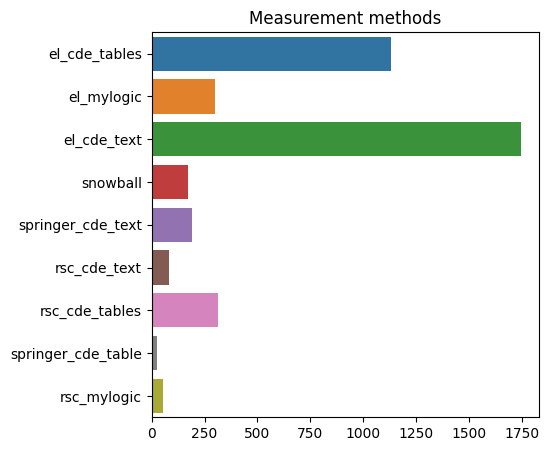

In [194]:
df2 = df.groupby(['measurement_method'])['measurement_method'].count()
labels = list(df['measurement_method'].unique())
data = list(df2)
sns.barplot(x=data, y=labels).set_title('Measurement methods')

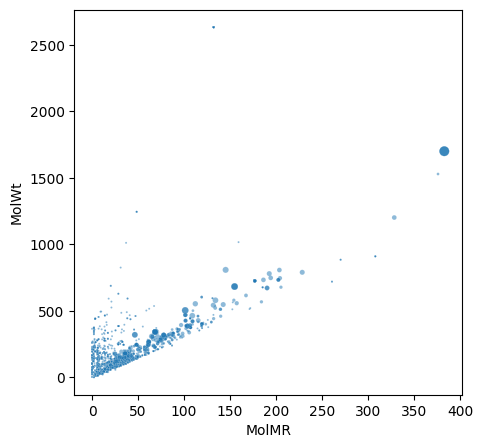

In [166]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.scatterplot(data=df, x="MolMR", y="MolWt", size="NumHDonors", legend=False, sizes=(2, 50), alpha=0.5)
plt.show()